In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append('../../')
from config import *

configure_pylab()

def poissonll(r,y,n,Fs = 50):
    ll = sum(n*(y*slog(r) - r))/sum(n) # nats/experiment
    return ll*Fs/log(2)
def llnodc(r,y,n):
    meanrate = sum(y*n)/sum(n)
    c = slog(meanrate)-slog(sum(r*n)/sum(n))
    lnλ = slog(r) + c
    λ = r*sexp(c)
    ll = sum(n*(y*lnλ-λ))/sum(n)
    return ll*Fs/log(2)
def ellnodc(u,r,y,n):
    meanrate = sum(y*n)/sum(n)
    c = slog(meanrate)-slog(sum(r*n)/sum(n))
    ll = sum(n*(y*(u+c)-r*sexp(c)))/sum(n)*Fs/log(2)
    return ll

print(len(datafiles))

Available files:
	r2288_180515b_tet2_cell2_GC.mat
	r2289_250515b_tet2_cell2_GC.mat
	r2298_290615c_tet6_cell6_GC.mat
	r2375_070416a_tet1_cell1_GC.mat
	r2375_140416b_tet1_cell1_GC.mat
	r2375_210416a_tet3_cell3_GC.mat
	r2383_160516b_tet4_cell4_GC.mat
	r2405_011216a_cell2955.mat
	r2405_051216b_cell1816.mat
	r2405_121216b_cell1880.mat
	r2405_121216b_cell1912.mat
	r2405_191216c_cell1640.mat
	r2405_191216c_cell1662.mat
	r2405_191216c_cell1962.mat
	r2405_191216c_cell1990.mat
Fitted models in fitdir = /home/mer49/Dropbox (Cambridge University)/Notebooks/PCV/LGCP/lgcpspatial v13/python/notebooks/hyperparameter_fits/
15


## Prepare simulated data 

/home/mer49/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


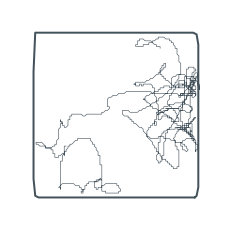

In [2]:
rate     = 1.2  # Spikes/second
Fs       = 50   # Samples/second
duration = 1800 # Seconds
T        = int(duration*Fs) # Samples
L        = 128  # Bins/arena
Po       = 13   # Bins/field

# Generate intensity map: Exponentiate and scale mean rate
λ0 = np.exp(ideal_hex_grid(L,Po)*0.5)

# Zero pad edges
pad  = L*15//100
mask = np.zeros((L,L),dtype='bool')
mask[pad:-pad,pad:-pad]=1
λ0 = λ0*mask

# Add background rate changes
coords = zgrid(L)
λ0_bg = λ0*(1-np.abs(coords/(L-2*pad)))

# Correct to reach target firing rate
correct = rate/mean(λ0_bg[mask>0])
λ0    *= correct
λ0_bg *= correct

# Simulate arena exploration
x  = float32([.5,.5])
xt = float32([.5,.5])
x2 = float32([.5,.5])
X  = zeros((T,2))
for t in range(T):
    xt = clip(xt+randn(2)*0.02,0,1)
    x2 = 0.9*x2 + 0.1*xt
    x  = 0.9*x  + 0.1*x2
    X[t,:] = x

# Sample grid cell spikes during exploration
YX   = int32(X*(L-2*pad)+pad)
rt   = λ0_bg[tuple(YX.T)]
s    = np.random.poisson(rt/Fs)
y,x  = YX.T/L

# Run inference
simulated_data = Dataset(x,y,s).prepare(L,margin=.15)

simulated_data.arena.imshow(NaN*λ0,color=BLACK,lw=2)
plot(x[1500:4500],y[1500:4500],lw=.6)

## Retrieve experimental data 

In [3]:
simulatedrefitPVθ = optimize_PVtheta(simulated_data.N,simulated_data.K,simulated_data.prior_mean,simulated_data.P,simulated_data.V)[0]

loaded_data = [(simulated_data, simulatedrefitPVθ)]
for f in datafiles:
    print(f)
    PVθ2 = pickle.load(open(fitdir + f[:-3]+'hyperparameters.p','rb'))
    loaded_data.append( ( Dataset.from_file(datadir+f).prepare(), PVθ2 ) )

[25,17](1.43e+01,2.09e-01) loss=-9.875488e+03(done)
Optimized parameters:                                                 
P = 14.281380
V = 0.228901
θ = 59.000000°
r2288_180515b_tet2_cell2_GC.mat
r2289_250515b_tet2_cell2_GC.mat
r2298_290615c_tet6_cell6_GC.mat
r2375_070416a_tet1_cell1_GC.mat
r2375_140416b_tet1_cell1_GC.mat
r2375_210416a_tet3_cell3_GC.mat
r2383_160516b_tet4_cell4_GC.mat
r2405_011216a_cell2955.mat
r2405_051216b_cell1816.mat
r2405_121216b_cell1880.mat
r2405_121216b_cell1912.mat
r2405_191216c_cell1640.mat
r2405_191216c_cell1662.mat
r2405_191216c_cell1962.mat
r2405_191216c_cell1990.mat


## Test models under cross-validation 

In [4]:
NXVAL   = 10

dbps = []
fed  = []

for data,PVθ2 in loaded_data:
    arena   = data.arena
    T       = len(data.spikes)
    (x,y),s = data.xy, data.spikes
    xys     = array([x,y,s]).T
    μ0      = data.prior_mean
    P = data.P
    V = data.V
    θ = data.angle
    μ = data.prior_mean
    P2,V2,θ2 = PVθ2
    σ = P2/pi/sqrt(2)

    bedges  = int32(linspace(0,T,NXVAL+1))
    bstart  = bedges[:-1]
    bstop   = bedges[1:]+1
    bedges  = array([bstart,bstop]).T

    llk,llg,llnull,llsat = [],[],[],[]
    for i,(a,b) in enumerate(zip(bstart,bstop)):
        train = concatenate([xys[:a],xys[b:]]).T
        test  = xys[a:b].T

        N,K = arena.binto(train[:2],train[2])
        rk  = kde(N,K,σ)
        
        # Re-optimized hyperparameters
        μ = slog(kde(N,K,σ*5))
        Ph,Vh,θh = data.heuristic_parameters(N,K)
        P3,V3,θ3 = optimize_PVtheta(N,K,μ,P,V)[0]
        
        rgs = []
        rgs.append(lgcp2d(kernelft(data.shape,Ph,Vh,style='grid',angle=θh),N,K,μ)[0].info)
        rgs.append(lgcp2d(kernelft(data.shape,Ph,Vh,style='radial'),N,K,μ)[0].info)
        rgs.append(lgcp2d(kernelft(data.shape,Ph,Vh,style='rbf'),N,K,μ)[0].info)
        rgs.append(lgcp2d(kernelft(data.shape,P3,V3,style='grid',angle=θ3),N,K,μ)[0].info)
        rgs.append(lgcp2d(kernelft(data.shape,P3,V3,style='radial'),N,K,μ)[0].info)
        rgs.append(lgcp2d(kernelft(data.shape,P3,V3,style='rbf'),N,K,μ)[0].info)

        N,K   = data.arena.binto(test[:2],test[2])
        Y     = sdiv(K,N)
        meanr = sum(Y*N)/sum(N)
        llnull.append(llnodc(meanr,Y,N))
        llsat .append(llnodc(Y,Y,N))
        llk   .append(llnodc(rk,Y,N))
        llg   .append([ellnodc(rg.mu,rg.r,Y,N) for rg in rgs])
    llk,llnull,llsat = map(mean,(llk,llnull,llsat))
    
    dbp = float32([llk-llnull] + [illg-llnull for illg in mean(float32(llg),axis=0)])
    dbps.append(dbp)
    fed.append(dbp/(llsat-llnull))
    
    #print('KDE FED:',(llk-llnull)/(llsat-llnull))
    print('KDE Δbps     :',llk-llnull)
    for i,llg in enumerate(mean(float32(llg),axis=0)):
        #print('kernel %d FED :'%i,(llg-llnull)/(llsat-llnull))
        print('kernel %d Δbps:'%i,llg-llnull)
        
    

[25,16](1.43e+01,2.29e-01) loss=-8.915644e+03(done)
Optimized parameters:                                                 
P = 13.890855
V = 0.228901
θ = 59.000000°
[25,17](1.43e+01,2.09e-01) loss=-8.808439e+03(done)
Optimized parameters:                                                 
P = 14.281380
V = 0.228901
θ = 59.000000°
[25,17](1.43e+01,2.09e-01) loss=-8.895867e+03(done)
Optimized parameters:                                                 
P = 14.281380
V = 0.228901
θ = 59.000000°
[25,17](1.43e+01,2.09e-01) loss=-8.857719e+03(done)
Optimized parameters:                                                 
P = 14.281380
V = 0.228901
θ = 59.000000°
[25,17](1.43e+01,2.09e-01) loss=-9.020105e+03(done)
Optimized parameters:                                                 
P = 14.281380
V = 0.228901
θ = 59.000000°
[25,17](1.43e+01,2.09e-01) loss=-8.814241e+03(done)
Optimized parameters:                                                 
P = 14.281380
V = 0.228901
θ = 59.000000°
[25,17](1.

In [5]:
fed   = float32(fed).T
dfed  = (fed-fed[0])*100
dbps  = float32(dbps).T
ddbps = dbps-dbps[0]

''

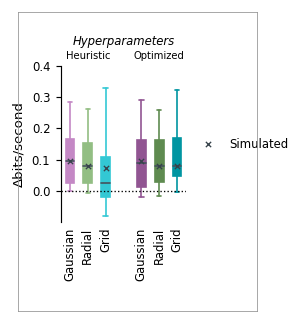

In [6]:
figure(0,(2,2.5),120)
subplots_adjust(0.18,.22,.7,.9)

colored_boxplot([ddbps[3][1:]],[3],lighten(MAUVE),widths=.5)
colored_boxplot([ddbps[2][1:]],[4],lighten(MOSS ),widths=.5)
colored_boxplot([ddbps[1][1:]],[5],lighten(TEAL),widths=.5)

colored_boxplot([ddbps[6][1:]],[7],darken(MAUVE),widths=.5)
colored_boxplot([ddbps[5][1:]],[8],darken(MOSS ),widths=.5)
colored_boxplot([ddbps[4][1:]],[9],darken(TEAL),widths=.5)

sk = dict(color=darken(BLACK),zorder=10,marker='x',s=10,lw=0.8)
scatter(3 ,ddbps[3][1],**sk)
scatter(4 ,ddbps[2][1],**sk)
scatter(5 ,ddbps[1][1],**sk)
scatter(7 ,ddbps[6][1],**sk)
scatter(8 ,ddbps[5][1],**sk)
scatter(9 ,ddbps[4][1],**sk,label='Simulated')
right_legend()

def dolabels():
    axhline(0,lw=.8,color='k',linestyle=':')
    xlim(0,10)
    simpleraxis()
    xticks([3,4,5,7,8,9],['Gaussian','Radial','Grid']*2,rotation=90)
    xticklen(0)
    ty = ylim()[1] + px2y(20)
    text(4,ty,'Heuristic',ha='center',va='top',fontsize=6)
    text(8,ty,'Optimized',ha='center',va='top',fontsize=6)
    text(6,ty+px2y(20),'Hyperparameters',ha='center',va='top',fontsize=7,fontstyle='italic')
    
yticks([0,.1,.2,.3,.4])
ylabel('Δbits/second')
dolabels()

force_aspect(.8)
figurebox()
savefig('f6v1a_bits_per_second.pdf')
;

''

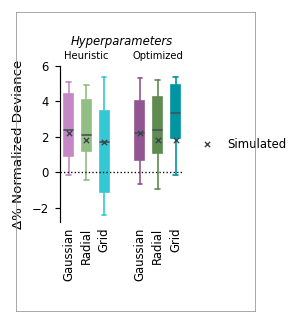

In [7]:
figure(0,(2,2.5),120)
subplots_adjust(0.18,.22,.7,.9)

colored_boxplot([dfed[3][1:]],[3],lighten(MAUVE),widths=.5)
colored_boxplot([dfed[2][1:]],[4],lighten(MOSS),widths=.5)
colored_boxplot([dfed[1][1:]],[5],lighten(TEAL),widths=.5)

colored_boxplot([dfed[6][1:]],[7],darken(MAUVE),widths=.5)
colored_boxplot([dfed[5][1:]],[8],darken(MOSS),widths=.5)
colored_boxplot([dfed[4][1:]],[9],darken(TEAL),widths=.5)

scatter(3 ,dfed[3][1],**sk)
scatter(4 ,dfed[2][1],**sk)
scatter(5 ,dfed[1][1],**sk)
scatter(7 ,dfed[6][1],**sk)
scatter(8 ,dfed[5][1],**sk)
scatter(9 ,dfed[4][1],**sk,label='Simulated')
right_legend()

yticks([-2,0,2,4,6])
#yticks([0,5,10])
dolabels()
ylabel('Δ% Normalized Deviance')

force_aspect(.8)
figurebox()
savefig('f6v1a_explained deviance.pdf')
;